# Assignment 1: Data Curation

DATA 512A Fall 2018

Ryan Bae

Due Date: Thursday October 18th, 2018


## Obtaining Data From Wikimedia API

This section contains code that pulls the necessary data from the Wikimedia API for page views of english wikipedia.org. The desired views are monthly total views for users only. 

The data is pulled from 2 sources, legacy page counts API and current page views API. For each source, following date ranges and page types are used:

* **Legacy Page Count API**
    * Date Range: December 2017 - July 2016
    * Page Type: desktop-site, mobile-site
    
  
* **Current Page View API**
    * Date Range: July 2015 - September 2018
    * Page Type: desktop-site, mobile-app, mobile-web
    

The downloaded data is saved as 5 separate json files, each for different page type in each API.

In [1]:
# imports
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
from functools import reduce

Below are parameters to accessing the API. 

In [2]:
# endpoints
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
# legacy pagecount paramters
params_legacy_desktop = {"project" : 'en.wikipedia.org',
                     "access-site" : "desktop-site",
                     "granularity" : "monthly",
                     "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                     "end" : "2016070100"
                    }
params_legacy_mobile = {"project" : 'en.wikipedia.org',
                     "access-site" : "mobile-site",
                     "granularity" : "monthly",
                     "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                     "end" : "2016070100"
                    }

# pageview parameters
params_pageviews_desktop = {"project" : 'en.wikipedia.org',
                        "access" : "desktop",
                        "agent" : "user",
                        "granularity" : "monthly",
                        "start" : "2015070100",
                        # for end use 1st day of month following final month of data
                        "end" : '2018100100'
                        }
params_pageviews_mobileapp = {"project" : 'en.wikipedia.org',
                        "access" : "mobile-app",
                        "agent" : "user",
                        "granularity" : "monthly",
                        "start" : "2015070100",
                        # for end use 1st day of month following final month of data
                        "end" : '2018100100'
                        }
params_pageviews_mobileweb = {"project" : 'en.wikipedia.org',
                        "access" : "mobile-web",
                        "agent" : "user",
                        "granularity" : "monthly",
                        "start" : "2015070100",
                        # for end use 1st day of month following final month of data
                        "end" : '2018100100'
                        }

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/ryanbae89',
    'From': 'rbae@uw.edu'
}

Below is the function for the API call. It takes in the endpoint and parameters specified above as input, and returns the data as response.

In [4]:
# function for API call
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

The function is called on 5 different page types to generate 5 dictionaries.

In [5]:
# get data from API
# Legacy Pagecounts (desktop-site)
monthly_pagecounts_desktop = api_call(endpoint_legacy, params_legacy_desktop)
# Legacy Pagecounts (mobile)
monthly_pagecounts_mobile = api_call(endpoint_legacy, params_legacy_mobile)
# Pageviews (desktop)
monthly_pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
# Pageviews (mobile-app)
monthly_pageviews_mobileapp = api_call(endpoint_pageviews, params_pageviews_mobileapp)
# Pageviews (mobile-web)
monthly_pageviews_mobileweb = api_call(endpoint_pageviews, params_pageviews_mobileweb)

Here the data is saved to json files, for each API/page type combination. There are total of 5 json files.

In [6]:
# save to json files
json_files = ['pagecounts_desktop-site_200712-201607.json',
              'pagecounts_mobile-site_200712-201607.json',
              'pageviews_desktop_201507-201809.json',
              'pageviews_mobile-app_201507-201809.json',
              'pageviews_mobile-web_201507-201809.json']
json_data = [monthly_pagecounts_desktop,
        monthly_pagecounts_mobile,
        monthly_pageviews_desktop,
        monthly_pageviews_mobileapp,
        monthly_pageviews_mobileweb]

for i, filename in enumerate(json_files):
    with open(filename, 'w') as outfile:
        json.dump(json_data[i], outfile)

## Data and Features Engineering

This section performs data and feature engineering on the downloaded json data. The json files have the following keys:

* **Legacy Page Count json file schema**
    * access-site
    * count
    * granularity
    * project 
    * timestamp

* **Current Page Views json file schema**
    * access
    * agent
    * granularity
    * project 
    * timestamp
    * views

It happens in the following steps:

* json files are converted to pandas dataframes
* *year* and *month* features are generated from *timestamp*
* *granularity*, *project*, and *timestamp* are dropped
* *view* and *count* are renamed according to the *access* and *access-site*
* *access* and *agent* are dropped
* mobile app and mobile web views are combined by joining on *year* and *month*
* rest of the tables are joined into one *view* table on *year* and *month*
* calculate all page count views and all page views for each API

Final *view* table has the following schema:

* year
* month
* pagecount_all_views
* pagecount_desktop_views
* pagecount_mobile_views
* pageview_all_views
* pageview_desktop_views
* pageview_mobile_views

And it is saved to a csv file.

In [8]:
# load json files and combine them into a table
pagecount_desktop = pd.DataFrame.from_dict(monthly_pagecounts_desktop['items'])
pagecount_mobile = pd.DataFrame.from_dict(monthly_pagecounts_mobile['items'])
pageview_desktop = pd.DataFrame.from_dict(monthly_pageviews_desktop['items'])
pageview_mobileapp = pd.DataFrame.from_dict(monthly_pageviews_mobileapp['items'])
pageview_mobileweb = pd.DataFrame.from_dict(monthly_pageviews_mobileweb['items'])

pagecount_desktop.name = 'pagecount_desktop'
pagecount_mobile.name = 'pagecount_mobile'
pageview_desktop.name = 'pageview_desktop'
pageview_mobileapp.name = 'pageview_mobileapp'
pageview_mobileweb.name ='pageview_mobileweb'

pages = [pagecount_desktop, pagecount_mobile, pageview_desktop,
         pageview_mobileapp, pageview_mobileweb]

Below *clean_data* function performs the data cleaning as described above.

In [11]:
# function for data engineering
def clean_data(df, pagetype):
    # get dataframe name for renaming view/count column
    view_str = df.name
    # get year and month for each row
    df['year'] = df['timestamp'].str[:4]
    df['month'] = df['timestamp'].str[4:6]
    # drop unnecessary columns
    df = df.drop(['granularity', 'project', 'timestamp'], axis=1)
    # rename view/count column and drop more unnecessary columns conditionally
    view_str = view_str + '_views'
    if pagetype == 'view':
        df = df.rename(index=str, columns={"views": view_str})
        df = df.drop(['access', 'agent'], axis=1)
    elif pagetype == 'count':
        df = df.rename(index=str, columns={"count": view_str})
        df = df.drop('access-site', axis=1)
    return df

# clean data and engineer year/month features
pagecount_desktop = clean_data(pagecount_desktop, 'count')
pagecount_mobile = clean_data(pagecount_mobile, 'count')
pageview_desktop = clean_data(pageview_desktop, 'view')
pageview_mobileapp = clean_data(pageview_mobileapp, 'view')
pageview_mobileweb = clean_data(pageview_mobileweb, 'view')

The page view for mobile app and mobile web are combined into page view for mobile below. This is done using an outer join on *year* and *month* columns between the two dataframes.

In [12]:
# join and sum pageviews_mobileapp and pageviews_mobileweb
pageview_mobile = pageview_mobileapp.merge(right=pageview_mobileweb,
                                             on=['year', 'month'], how='outer')
pageview_mobile['pageview_mobile_views'] = pageview_mobile['pageview_mobileweb_views'] + pageview_mobile['pageview_mobileapp_views']
pageview_mobile = pageview_mobile[['year', 'month', 'pageview_mobile_views']]
pageview_mobile.head()

,year,month,pageview_mobile_views
0,2015,07,3288755294
1,2015,08,3302333038
2,2015,09,3170203333
3,2015,10,3268499132
4,2015,11,3236601070


Now all 4 dataframes are outer-joined on *year* and *month* to generate the final *views* dataframe. Then the desktop and mobile views for each API are added to generate all_views feature. All NaN values are filled with 0 and column names are reordered.

In [16]:
# join all the tables into a single table for plotting
pages = [pagecount_desktop, pagecount_mobile, pageview_desktop, pageview_mobile]
views = reduce(lambda left, right: pd.merge(left, right, on=['year', 'month'],
               how='outer'), pages)
# fill nans
views = views.fillna(value=0)
# engineer all_views features
views['pagecount_all_views'] = views['pagecount_desktop_views'] + views['pagecount_mobile_views']
views['pageview_all_views'] = views['pageview_desktop_views'] + views['pageview_mobile_views']
# reorder columns
views = views[['year', 'month', 'pagecount_all_views',
              'pagecount_desktop_views', 'pagecount_mobile_views',
              'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]
views.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.0,0.0,0.0
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.0,0.0,0.0
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.0,0.0,0.0
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.0,0.0,0.0


The *views* dataframe is saved to csv below.

In [30]:
# save views to csv
views.to_csv('en-wikipedia_traffic_200712-201809.csv')

## Visualization

The visualization is a plot of the monthly views for each API and page type. First, the date range is genreated for plotting purposes. 

In [17]:
# get time feature for plotting
year_month = pd.DatetimeIndex(start='2007-12-01',end='2018-10-01' , freq='M')
year_month

DatetimeIndex(['2007-12-31', '2008-01-31', '2008-02-29', '2008-03-31',
               '2008-04-30', '2008-05-31', '2008-06-30', '2008-07-31',
               '2008-08-31', '2008-09-30',
               ...
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30'],
              dtype='datetime64[ns]', length=130, freq='M')

The plotting is done in code block below. Values of 0's are not plotted, and this is done by manually specifying start and end to the columns (*start_count*, *end_count*, and *start_view*).

Also, the view counts themselves are divided by 1,000,000 so the viewer can interpret the y-axis more easily. 

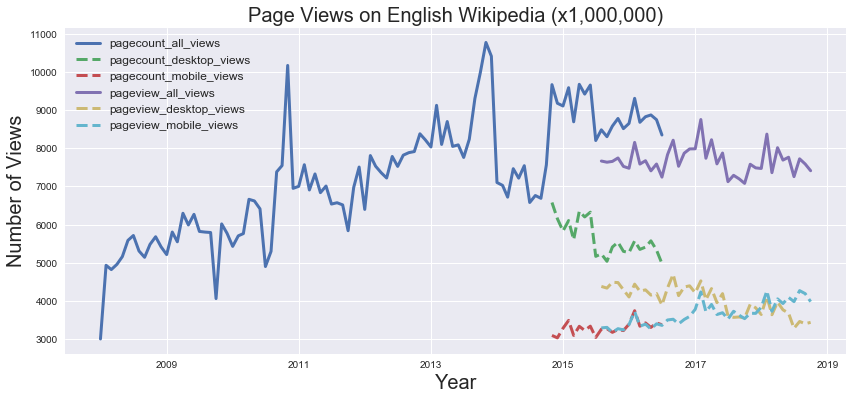

In [18]:
# plot range and parameters
start_count = 82
end_count = 103
start_view = 91
lw = 3.0
views_factor = 1e6

# plot visualization
fig, axs = plt.subplots(1, 1, figsize=(14,6))

plt.plot(year_month[:end_count], views['pagecount_all_views'][:end_count]/views_factor,
         ls='-', linewidth=lw)
plt.plot(year_month[start_count:end_count], views['pagecount_desktop_views'][start_count:end_count]/views_factor,
         ls='--', linewidth=lw)
plt.plot(year_month[start_count:end_count], views['pagecount_mobile_views'][start_count:end_count]/views_factor, 
         ls='--', linewidth=lw)
plt.plot(year_month[start_view:], views['pageview_all_views'][start_view:]/views_factor, 
         ls='-', linewidth=lw)
plt.plot(year_month[start_view:], views['pageview_desktop_views'][start_view:]/views_factor, 
         ls='--', linewidth=lw)
plt.plot(year_month[start_view:], views['pageview_mobile_views'][start_view:]/views_factor, 
         ls='--', linewidth=lw)

plt.title('Page Views on English Wikipedia (x1,000,000)', fontsize=20)
plt.legend(prop={'size': 12})
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of Views', fontsize=20)

plt.show()

The figure generated above is saved as png file below.

In [19]:
# save figure 
fig.savefig('a1-visualization.png')